# EuroSAT Land use Classification using ResNet34

## Importing the Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


Setting seed for reproducibility

In [2]:
seed = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(seed)

## Loading the Dataset

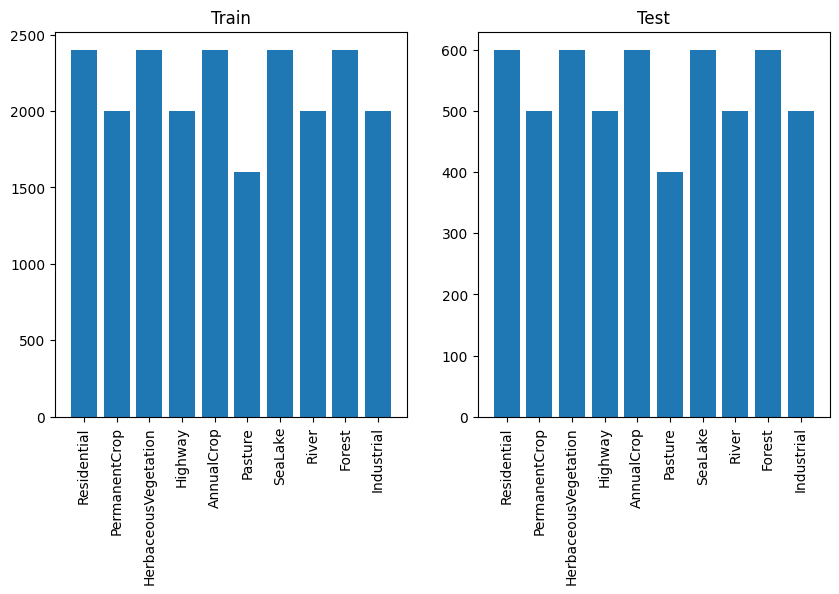

In [3]:
data_dir = "../data/EuroSAT_RGB/"

train_df = pd.DataFrame(columns=["image", "label"])
test_df = pd.DataFrame(columns=["image", "label"])
classes = os.listdir(data_dir)
class_to_idx = {classes[i]: i for i in range(len(classes))}
idx_to_class = {i: classes[i] for i in range(len(classes))}

for cls in classes:
    images =  [os.path.join(data_dir, cls, i) for i in os.listdir(os.path.join(data_dir, cls))]
    labels = [class_to_idx[cls]] * len(images)
    df = pd.DataFrame({"image": images, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)
    train_df = pd.concat([train_df, df.iloc[:int(0.8*len(df))]], ignore_index=True)
    test_df = pd.concat([test_df, df.iloc[int(0.8*len(df)):]], ignore_index=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plt.bar(classes, [len(train_df[train_df["label"] == class_to_idx[i]]) for i in classes])
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.title("Test")
plt.bar(classes, [len(test_df[test_df["label"] == class_to_idx[i]]) for i in classes])
plt.xticks(rotation=90)
plt.show()

In [4]:
class EuroSAT_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image']
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        label = self.df.iloc[idx]['label']
        
        return img, label

In [5]:
normalise_means = [0.4914, 0.4822, 0.4465]
normalise_stds = [0.2023, 0.1994, 0.2010]

train_transform = T.Compose([T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(normalise_means, normalise_stds),])

test_transforms = T.Compose([T.ToTensor(), T.Normalize(normalise_means, normalise_stds)])

train_dataset = EuroSAT_Dataset(train_df, train_transform)
test_dataset = EuroSAT_Dataset(test_df, test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

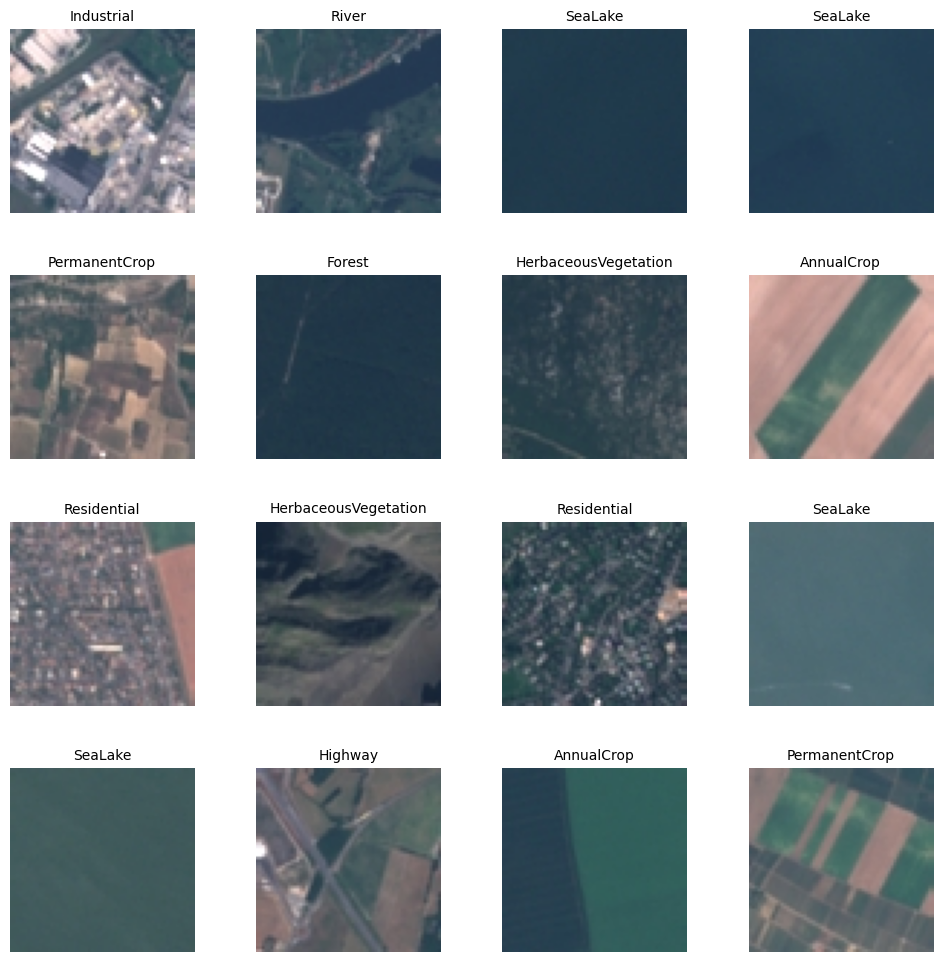

In [6]:
def denormalize(img):
    means = torch.tensor(normalise_means).view(3, 1, 1)
    stds = torch.tensor(normalise_stds).view(3, 1, 1)
    return img * stds + means

def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))
    fig.tight_layout()
    for i in range(4):
        for j in range(4):
            image = denormalize(images[i*4 + j]).permute(1, 2, 0)
            label = labels[i*4 + j].item()
            ax[i][j].imshow((image.numpy() * 255).astype(np.uint8))
            title = class_map[label]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, idx_to_class)

## Defining the Model

In [7]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride= 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride= stride, padding= 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride= 1, padding= 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace= True)

        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1))
        
        if stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.downsample(x)

        out = self.relu(out)

        return out

class ResNet34(nn.Module):
    def __init__(self, in_channels, num_classes) -> None:
        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, 7, stride= 2, padding= 3),
            nn.BatchNorm2d(64), nn.MaxPool2d(2, stride= 1), nn.ReLU(inplace= True))

        self.layer0 = self._make_layer(64, 64, 3, 1)
        self.layer1 = self._make_layer(64, 128, 4, 2)
        self.layer2 = self._make_layer(128, 256, 6, 2)
        self.layer3 = self._make_layer(256, 512, 3, 2)

        self.avg_pool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))

        for i in range(num_blocks - 1):
            layers.append(BasicBlock(out_channels, out_channels, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        
        out = self.layer0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [8]:
model = ResNet34(3, 10).to(device)
print(model)

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (layer0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

## Training 

In [9]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, testloader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(testloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_test_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_test_loss / len(testloader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), '../models/model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")

    return train_losses, train_acc, test_losses, test_acc

In [10]:
epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.001)

train_losses, train_acc, test_losses, test_acc = train(model, epochs, optimizer, criterion, scheduler, device, train_loader, test_loader)
print("  Finished Training  ")

Epoch: 1


Test	: 100%|██████████| 338/338 [00:07<00:00, 44.32it/s]


Train Loss: 1.307, Train Acc: 0.530, Test Loss: 1.158, Test Acc: 0.614

Epoch: 2


Test	: 100%|██████████| 338/338 [00:07<00:00, 42.37it/s]


Train Loss: 0.913, Train Acc: 0.679, Test Loss: 0.911, Test Acc: 0.691

Epoch: 3


Test	: 100%|██████████| 338/338 [00:07<00:00, 45.34it/s]


Train Loss: 0.741, Train Acc: 0.743, Test Loss: 0.886, Test Acc: 0.705

Epoch: 4


Test	: 100%|██████████| 338/338 [00:07<00:00, 43.64it/s]


Train Loss: 0.626, Train Acc: 0.785, Test Loss: 0.715, Test Acc: 0.763

Epoch: 5


Test	: 100%|██████████| 338/338 [00:07<00:00, 44.23it/s]


Train Loss: 0.538, Train Acc: 0.814, Test Loss: 0.666, Test Acc: 0.782

Epoch: 6


Test	: 100%|██████████| 338/338 [00:07<00:00, 45.27it/s]


Train Loss: 0.457, Train Acc: 0.844, Test Loss: 0.621, Test Acc: 0.797

Epoch: 7


Test	: 100%|██████████| 338/338 [00:07<00:00, 44.61it/s]


Train Loss: 0.386, Train Acc: 0.870, Test Loss: 0.505, Test Acc: 0.831

Epoch: 8


Test	: 100%|██████████| 338/338 [00:07<00:00, 43.85it/s]


Train Loss: 0.341, Train Acc: 0.885, Test Loss: 0.446, Test Acc: 0.858

Epoch: 9


Test	: 100%|██████████| 338/338 [00:07<00:00, 44.54it/s]


Train Loss: 0.284, Train Acc: 0.903, Test Loss: 0.448, Test Acc: 0.851

Epoch: 10


Test	: 100%|██████████| 338/338 [00:07<00:00, 43.76it/s]


Train Loss: 0.247, Train Acc: 0.917, Test Loss: 0.413, Test Acc: 0.869

Epoch: 11


Test	: 100%|██████████| 338/338 [00:07<00:00, 44.34it/s]


Train Loss: 0.208, Train Acc: 0.928, Test Loss: 0.394, Test Acc: 0.873

Epoch: 12


Test	: 100%|██████████| 338/338 [00:07<00:00, 45.21it/s]


Train Loss: 0.167, Train Acc: 0.943, Test Loss: 0.379, Test Acc: 0.877

Epoch: 13


Test	: 100%|██████████| 338/338 [00:07<00:00, 45.41it/s]


Train Loss: 0.147, Train Acc: 0.951, Test Loss: 0.352, Test Acc: 0.888

Epoch: 14


Test	: 100%|██████████| 338/338 [00:07<00:00, 44.72it/s]


Train Loss: 0.117, Train Acc: 0.960, Test Loss: 0.367, Test Acc: 0.884

Epoch: 15


Test	: 100%|██████████| 338/338 [00:07<00:00, 44.78it/s]


Train Loss: 0.097, Train Acc: 0.967, Test Loss: 0.307, Test Acc: 0.903

Epoch: 16


Test	: 100%|██████████| 338/338 [00:08<00:00, 41.51it/s]


Train Loss: 0.078, Train Acc: 0.975, Test Loss: 0.306, Test Acc: 0.903

Epoch: 17


Test	: 100%|██████████| 338/338 [00:08<00:00, 40.67it/s]


Train Loss: 0.059, Train Acc: 0.982, Test Loss: 0.303, Test Acc: 0.905

Epoch: 18


Test	: 100%|██████████| 338/338 [00:08<00:00, 40.40it/s]


Train Loss: 0.049, Train Acc: 0.985, Test Loss: 0.318, Test Acc: 0.904

Epoch: 19


Test	: 100%|██████████| 338/338 [00:08<00:00, 40.07it/s]


Train Loss: 0.043, Train Acc: 0.987, Test Loss: 0.306, Test Acc: 0.907

Epoch: 20


Test	: 100%|██████████| 338/338 [00:08<00:00, 40.52it/s]


Train Loss: 0.037, Train Acc: 0.990, Test Loss: 0.309, Test Acc: 0.904

  Finished Training  


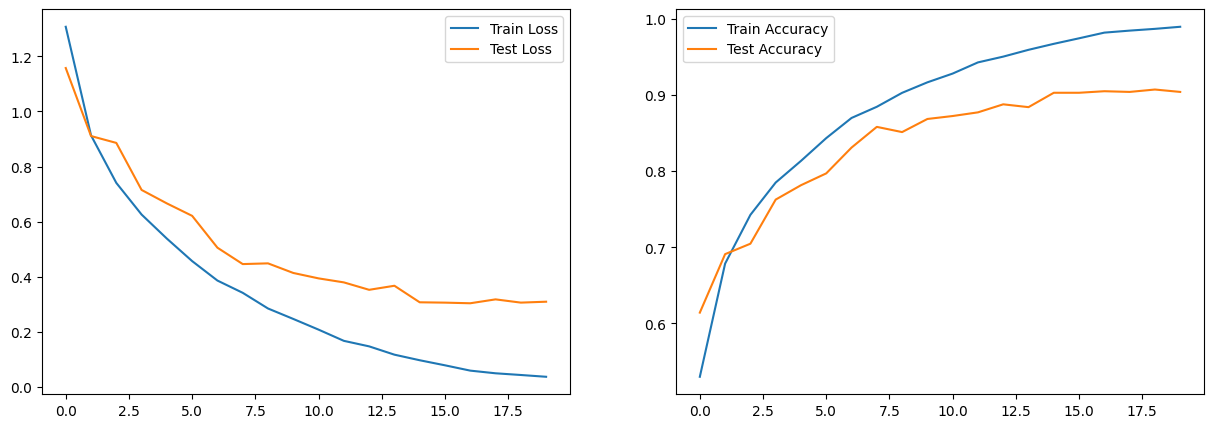

In [11]:
def plot_graphs(train_losses, train_acc, val_losses, val_acc):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Test Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Test Accuracy")
    plt.legend()
    plt.show()

plot_graphs(train_losses, train_acc, test_losses, test_acc)

## Testing

In [12]:
def test(model, testloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in testloader:
            images, targets = images.to(device), targets.to(device)
            output = model(images)
            preds = torch.argmax(output, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    print(f"Test Accuracy: {correct / total:.3f}")

test(model, test_loader, device)

Test Accuracy: 0.906


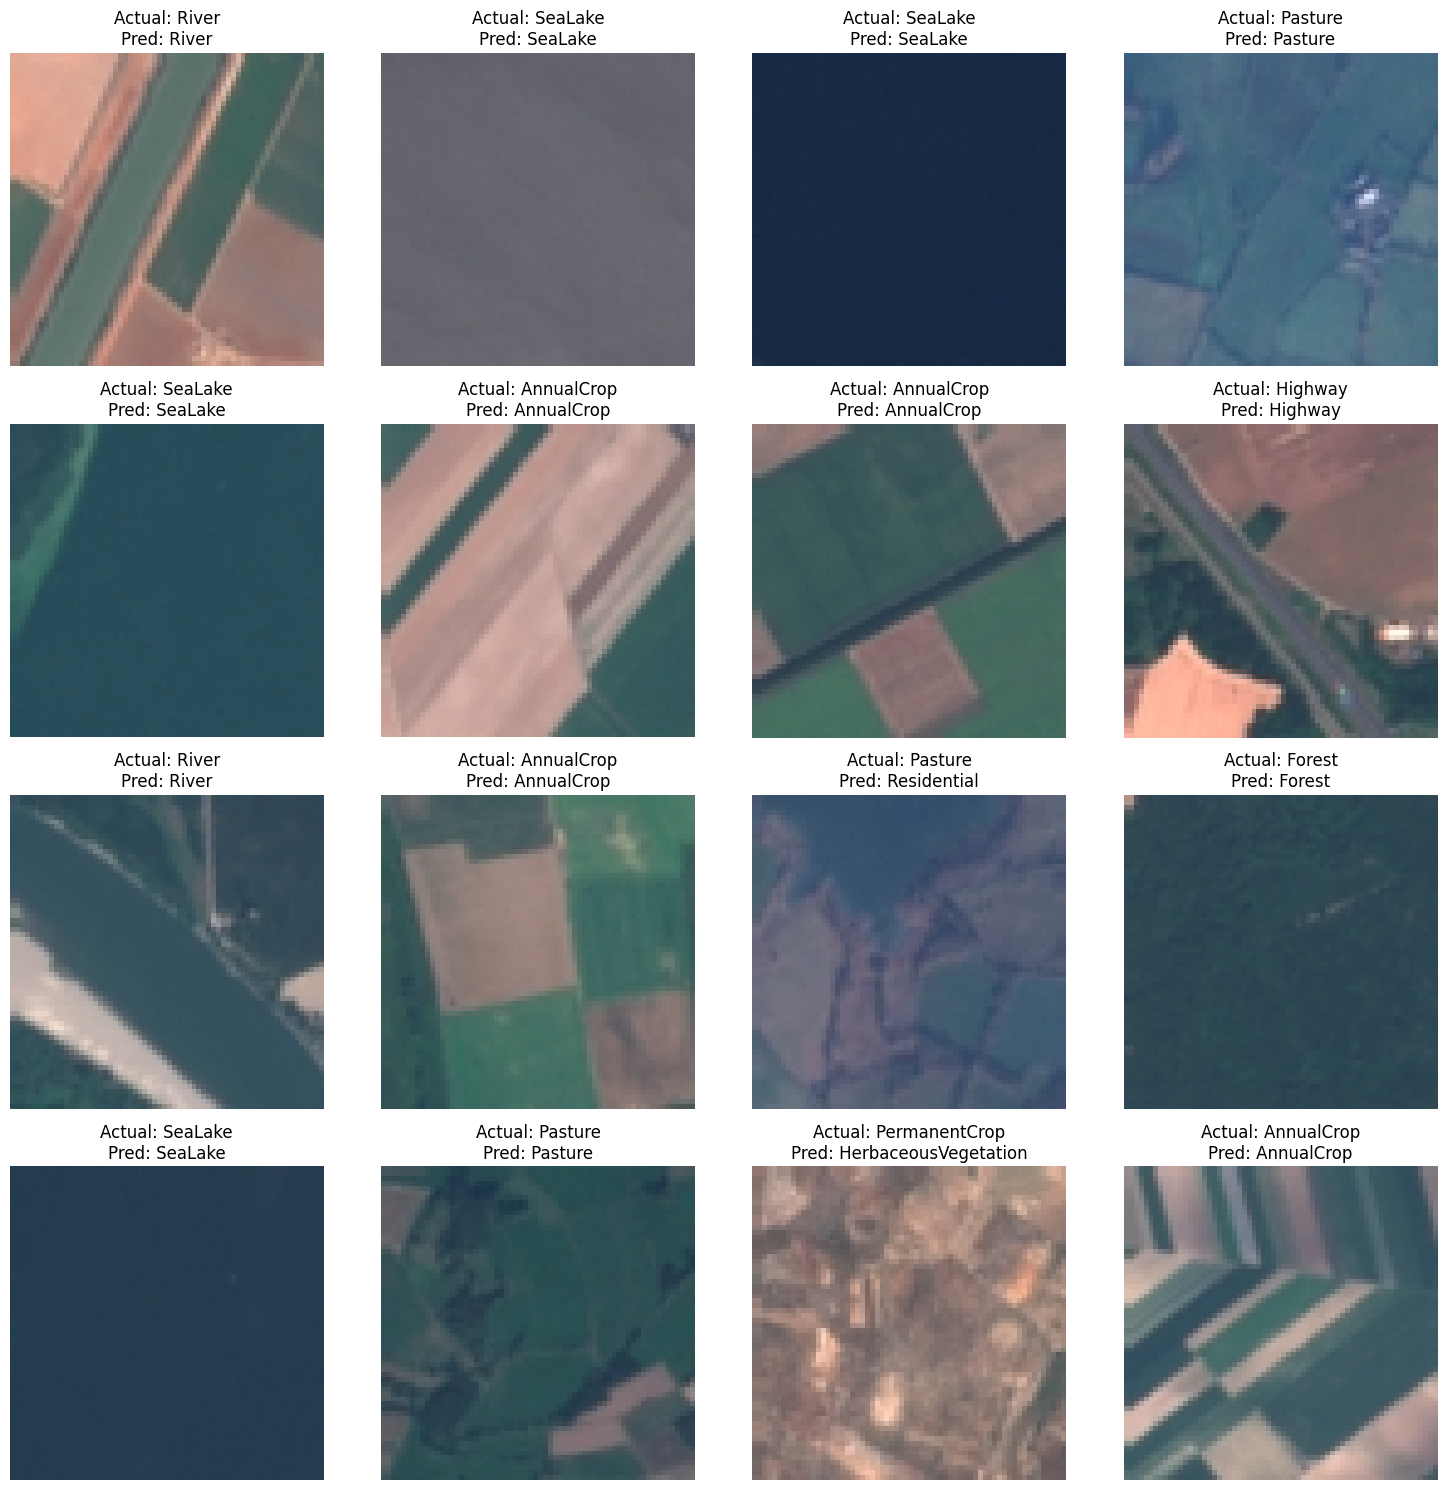

In [13]:
def show_test_batch(images, preds, targets, class_map):
    images = denormalize(images.cpu())
    images = images.numpy()
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()

    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    fig.tight_layout()
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(np.transpose(images[i*4+j], (1, 2, 0)))
            ax[i, j].set_title(f"Actual: {class_map[targets[i*4+j]]}\nPred: {class_map[preds[i*4+j]]}")
            ax[i, j].axis("off")

images, targets = next(iter(test_loader))
images, targets = images.to(device), targets.to(device)
output = model(images)
preds = torch.argmax(output, dim=1)

show_test_batch(images, preds, targets, idx_to_class)

## Saving the Model

In [14]:
import json

torch.save(model.state_dict(), '../models/model.pth')
json.dump( idx_to_class, open( "../models/idx_to_class.json", 'w' ) )